Metropolis-Hastings algoritmi

- algoritmi za uzorkovanje iz distribucija iz kojih je teško izravno uzorkovati
- temelje se na konstruiranju Markovljevog lanca koji ima željenu stacionarnu distribuciju



Preduvjeti za osnovnu implementaciju:

- moći uzorkovati neku drugu, jednostavniju, probnu distribuciju ("proposal distribution") q(y|x) uz x koji odgovara trenutnom stanju lanca
- odabir probne distribucije je ključan za konvergenciju i učinkovitost algoritma, njena potpora bi trebala biti nadskup potpore ciljne distribucije
- moći izračunati p(x) za ciljnu distribuciju

Osnovna implementacija:

In [45]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

#probna distribucija, moramo moći uzorkovati q(y|x) i izračunati q(y|x)
class ConditionalDistribution(ABC):
   @abstractmethod
   def sample(self, x):
      pass
   
   @abstractmethod
   def pdf(self, x, y):
      pass

class TargetDistribution(ABC):
   @abstractmethod
   def pdf(self, x):
      pass

#p - pdf ciljne distribucije
def MetropolisHastings(p: TargetDistribution, q : ConditionalDistribution, x0 = 0, N = 5000, acceptanceRate = False):
   x = x0
   samples = [x]
   accepted = []
   for i in range(N + N//5 - 1):
      y = q.sample(x)
      alpha = 1
      if (p.pdf(x) != 0 and q.pdf(x, y) != 0):
         alpha = min(1, p.pdf(y) / p.pdf(x) * q.pdf(x, y) / q.pdf(y, x))
      u = np.random.uniform(0, 1)
      if u < alpha:
         x = y
         accepted.append(1)
      else:
         accepted.append(0)
      samples.append(x)

   accepted = accepted[N//5::]
   return samples[N//5::] if not acceptanceRate else (samples[N//5::], sum(accepted) / len(accepted))

Objašnjenje koda:

- iz uvjetne distribucije i prošlog stanja x, uzorkujemo novo potencijalno stanje, odnosno vrijednost
- s vjerojatnošću alfa - min(1, p(y)/p(x) * q(y|x)/q(x|y)) prihvaćamo y kao sljedeće stanje, u suprotnom zadržavamo prošlo stanje - na ovaj način postižemo stacionarnu distribuciju ciljne funkcije
- ovaj postupak prihvaćanja "lošijeg" stanja sličan je algoritmu simuliranog kaljenja ("simulated annealing")
- generiramo dodatnih 20% "početnih" uzoraka kako bismo pustili algoritmu da na početku konvergira prema sredini ciljne distribucije ("burn in period")
- stopa prihvaćanja objašnjena kasnije u bilježnici

Primjer korištenja - uzorkovanje iz Beta(2,5) distribucije koristeći jednoliku [0,1] distribuciju:



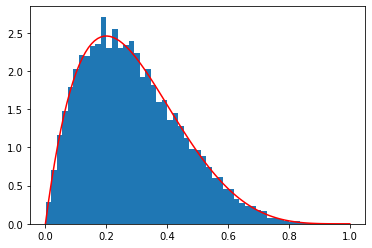

In [46]:
class UniformDistribution(ConditionalDistribution):
   def __init__(self, a, b):
      self.a = a
      self.b = b

   def sample(self, x):
      return np.random.uniform(self.a, self.b)

   def pdf(self, x, y):
      return 1 / (self.b - self.a)
   
class BetaDistribution(TargetDistribution):
   def __init__(self, alpha, beta):
      self.alpha = alpha
      self.beta = beta

   def pdf(self, x):
      return stats.beta.pdf(x, self.alpha, self.beta)

unif01 = UniformDistribution(0, 1)
beta = BetaDistribution(2, 5)
samples = MetropolisHastings(beta, unif01, N = 20000)

#histogram uzoraka
plt.hist(samples, bins = 50, density = True)
plt.plot(np.linspace(0, 1, 100), beta.pdf(np.linspace(0, 1, 100)), 'r')

- kad koristimo jednoliku distribuciju algoritam je poprilično jednostavniji jer je q(y|x)/q(x|y) uvijek 1 pa taj član možemo i ukloniti
- ovo vrijedi za sve uvjetne distribucije u kojima q(y|x) = q(x|y)
- primjetimo da Beta distribucija ima potporu [0,1] koja odgovara našem odabiru probne distribucije

2. primjer korištenja - uzorkovanje iz Cauchy(0,1) distribuciju koristeći probnu normalnu N(0,1) distribuciju

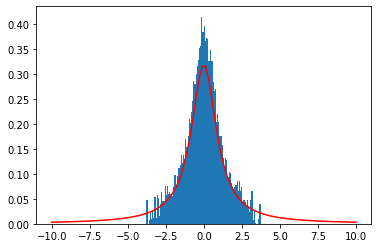

In [47]:
class CauchyDistribution(TargetDistribution):
   def __init__(self, x0, gamma):
      self.x0 = x0
      self.gamma = gamma

   def pdf(self, x):
      return stats.cauchy.pdf(x, self.x0, self.gamma)
   
class NormalDistribution(ConditionalDistribution):
   def __init__(self, mu, sigma):
      self.mu = mu
      self.sigma = sigma

   def sample(self, x):
      return np.random.normal(self.mu, self.sigma)

   def pdf(self, x, y):
      return stats.norm.pdf(x, self.mu, self.sigma)
   
cauchy01 = CauchyDistribution(0, 1)
normal = NormalDistribution(0, 1)

samples = MetropolisHastings(cauchy01, normal, N = 20000)
plt.hist(samples, bins = 100, density = True)
plt.plot(np.linspace(-10, 10, 100), cauchy01.pdf(np.linspace(-10, 10, 100)), 'r')

neke vrijednosti strše zbog uvjeta prihvaćanja, tj. zapinjanja na jednom stanju iako algoritam svejedno u teoriji konvergira prema ciljnoj distribuciji

Metropolis-Hastings varijanta slučajne šetnje

- kandidat y se uzorkuje iz susjedstva prethodnog rješenja s nekom simetričnom distribucijom, npr. jednolikom U(x-a,x+a) ili normalnom N(x,std)
- za konvergenciju važno odbaciti y kojim se izlazi iz potpore ciljane distribucije, i to tako da se x zadrži
- odabir širine susjedstva mora biti prilagođen ciljnoj distribuciji - premalo susjedstvo uzrokuje nedovoljnu eksploraciju, a preveliko susjedstvo prečesto odbacivanje

Kod za varijantu slučajne šetnje:

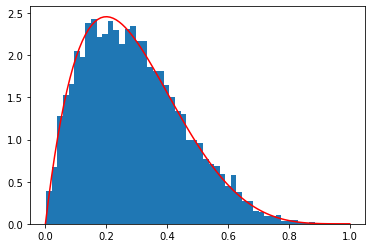

In [48]:
class NeighbourhoodDistribution(ABC):
   def sample(self, x):
      pass

class NormalNeighbourhood(NeighbourhoodDistribution):
   def __init__(self, sigma):
      self.sigma = sigma

   def sample(self, x):
      return np.random.normal(x, self.sigma)
   
def RandomWalkMetropolisHastings(p: TargetDistribution, q : NeighbourhoodDistribution, x0 = 0, N = 5000, acceptanceRate = False):
   x = x0
   samples = [x]
   accepted = []
   for i in range(N + N//5 - 1):
      y = q.sample(x)
      if (p.pdf(y) == 0):
         alpha = 0
      elif (p.pdf(x) == 0):
         alpha = 1
      else:
         alpha = min(1, p.pdf(y) / p.pdf(x))
      u = np.random.uniform(0, 1)
      if u < alpha:
         x = y
         accepted.append(1)
      else:
         accepted.append(0)
      samples.append(x)

   accepted = accepted[N//5::]
   return samples[N//5::] if not acceptanceRate else (samples[N//5::], sum(accepted) / len(accepted))

normalNeighbourhood = NormalNeighbourhood(0.2)
samples = RandomWalkMetropolisHastings(beta, normalNeighbourhood, N=20000)
plt.hist(samples, bins = 50, density = True)
plt.plot(np.linspace(0, 1, 100), beta.pdf(np.linspace(0, 1, 100)), 'r')

Odabir probne distribucije - usporedba različitih Metropolis-Hastings algoritama

- za konvergenciju je idealna probna distribucija upravo ona koju uzorkujemo, no to je naravno besmisleno raditi jer nju ne znamo direktno uzorkovati, zato želimo uzeti distribuciju sličnu traženoj, ali "jednostavniju"
- stopa prihvaćanja ("acceptance rate") nam daje omjer prihvaćenih uzorkovanih vrijednosti iz probne distribucije, te nam daje mjeru s kojom možemo uspoređivati različite odabire probnih distribucija
- ova mjera s može zavarati za algoritam sa slučajnom šetnjom - velika stopa prihvaćanja može značiti da se ne krećemo dovoljno po potpori tražene distribucije
- istraživanja upućuju da za algoritam slučajne šetnje dobru konvergenciju pokazuju distribucije susjedstva s stopom prohvaćanja od ~ 0.5 za manje dimenzije (1 i 2) i ~ 0.25 za veće dimenzije

Primjeri izračuna stope prihvaćanja (standardni algoritam):


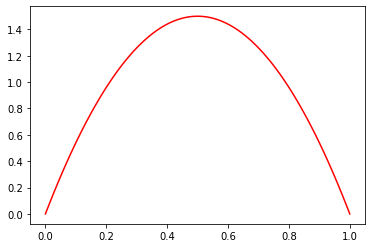

Stopa prihvaćanja za normalnu distribuciju sa središtem u 0: 0.17543508701740348
Stopa prihvaćanja za normalnu distribuciju sa središtem u 0.5: 0.8577715543108622
Stopa prihvaćanja za jednoliku U(0,1) distribuciju: 0.7455491098219644
Stopa prihvaćanja za beta(2,2) distribuciju: 1.0


In [49]:
class BetaConditional(ConditionalDistribution):
   def __init__(self, alpha, beta):
      self.alpha = alpha
      self.beta = beta

   def sample(self, x):
      return np.random.beta(self.alpha, self.beta)

   def pdf(self, x, y):
      return stats.beta.pdf(x, self.alpha, self.beta)

beta22 = BetaDistribution(2, 2)
beta22Conditional = BetaConditional(2, 2)

plt.plot(np.linspace(0, 1, 100), beta22.pdf(np.linspace(0, 1, 100)), 'r')
plt.show()

normal0 = NormalDistribution(0, 0.3)
normal05 = NormalDistribution(0.5, 0.3)

samples, acceptance = MetropolisHastings(beta22, normal0, acceptanceRate = True)
print("Stopa prihvaćanja za normalnu distribuciju sa središtem u 0:", acceptance)

samples, acceptance = MetropolisHastings(beta22, normal05, acceptanceRate = True)
print("Stopa prihvaćanja za normalnu distribuciju sa središtem u 0.5:", acceptance)

samples, acceptance = MetropolisHastings(beta22, unif01, acceptanceRate = True)
print("Stopa prihvaćanja za jednoliku U(0,1) distribuciju:", acceptance)

samples, acceptance = MetropolisHastings(beta22, beta22Conditional, acceptanceRate = True)
print("Stopa prihvaćanja za beta(2,2) distribuciju:", acceptance)


- očekivano najgoru stopu prihvaćanja ima normalna distribucija sa središtem u 0 jer u 50% slučajeva nećemo ni biti u potpori tražene distribucije
- jednolika distribucija je dobra, ali lošija od normalne s prikladnim središtem i varijancom jer ne preferira vrijednosti u sredini distribucije
- kad su tražena i probna distribucija jednake stopa prihvaćanja je očekivano 1

Primjer usporedbe kod algoritma slučajne šetnje:

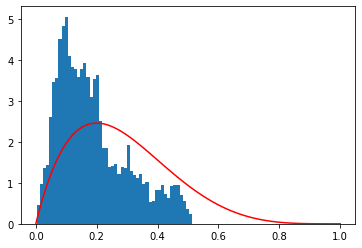

Stopa prihvaćanja za normalnu distribuciju s malom varijancom: 0.9781956391278256


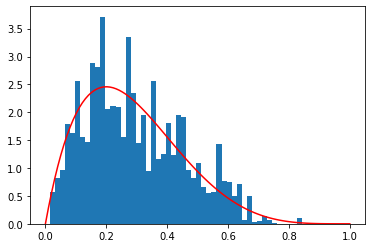

Stopa prihvaćanja za normalnu distribuciju s velikom varijancom: 0.09441888377675535


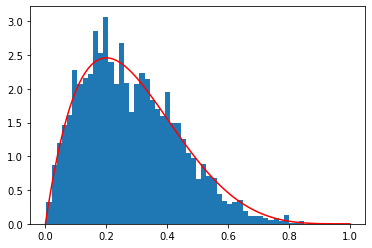

Stopa prihvaćanja za normalnu distribuciju s optimalnom varijancom: 0.6411282256451291


In [50]:
normalNeighbourhoodSmall = NormalNeighbourhood(0.01)
samples, acceptance = RandomWalkMetropolisHastings(beta, normalNeighbourhoodSmall, N=5000, acceptanceRate = True)
plt.hist(samples, bins = 50, density = True)
plt.plot(np.linspace(0, 1, 100), beta.pdf(np.linspace(0, 1, 100)), 'r') 
plt.show()
print("Stopa prihvaćanja za normalnu distribuciju s malom varijancom:", acceptance)

normalNeighbourhoodLarge = NormalNeighbourhood(2)
samples, acceptance = RandomWalkMetropolisHastings(beta, normalNeighbourhoodLarge, N=5000, acceptanceRate = True)
plt.hist(samples, bins = 50, density = True)
plt.plot(np.linspace(0, 1, 100), beta.pdf(np.linspace(0, 1, 100)), 'r')
plt.show()
print("Stopa prihvaćanja za normalnu distribuciju s velikom varijancom:", acceptance)

normalNeighbourhoodOptimal = NormalNeighbourhood(0.2)
samples, acceptance = RandomWalkMetropolisHastings(beta, normalNeighbourhoodOptimal, N=5000, acceptanceRate = True)
plt.hist(samples, bins = 50, density = True)
plt.plot(np.linspace(0, 1, 100), beta.pdf(np.linspace(0, 1, 100)), 'r')
plt.show()
print("Stopa prihvaćanja za normalnu distribuciju s optimalnom varijancom:", acceptance)